# EfficientDet for Edge-Aware Image Segmentation

In this task - one should implement a part of the one of the state-of-the-art NN architecture for dense predictions - [EfficientDet](https://arxiv.org/pdf/1911.09070.pdf) - called the BiFPN feature combinator. Then one should use the features from the FPN as an input to two heads: one for an person segmentation (single class) and other for an edge detection. This network should be trained on the PennFundan dataset with traditional augmentations.

## Dataset and augmentations (2pt)

Our dataset is a modified [PennFundan](https://www.cis.upenn.edu/~jshi/ped_html/) dataset (known from a previous task). For each image $I$ in this dataset and its pedestrians masks $M^{I}_{1}, ... M^{I}_{n}$ we generate a dataset consisting of $n$ new images and their corresponding masks (both person and edge ones): $\{(DI^{I}_{1} , DM^{I}_{1}, DE^{I}_{1}),  ... (DI^{I}_{n}, DM^{I}_{n}, DE^{I}_{n})\}$. For each $i = 1, .. ,n$, $DI^{I}_{i}$ is obtained by first extending the minimal bounding box encircling a mask $M^{I}_{i}$ by 12 pixels (if possible, if not - by a maximal possible number of pixels) in each direction and then resizing it to a square of size $(128, 128)$. Mask $DM^{I}_{i}$ is obtained in the same manner and it is downscaled to the size of $(64, 64)$. For each mask - its edge mask $DE^{I}$ is computed as a mask for those pixels $p$ in the person mask for which there exist two pixels $p_m, p_b$ distant from $p$ by at most 2 in $L^{\inf}$ distance on the image for which $p_m$ belongs to a person mask and $p_b$ does not.

Your task is to implement a function `get_edge_of_mask` that extracts the edge of the mask (1pt).

**Hint**: the edge mask may be easily computed using convolution.

**Clarification**:

$$L^{\inf}((x_1^1, x_2^1), (x_1^2, x_2^2) = \max_{i = 1, 2} |x_i^1 - x_i^2|.$$

One should also implement a set of at least three standard image / mask augmentations (e.g., flips, rotations, etc.). They should be applied to image, person mask and edge mask in a consistent manner (1pt).

##BiFPN (3pts)

One should implement a BIFPN module with a pixel-wise weighted feature fusion as described in section 3.3 of [this](https://arxiv.org/pdf/1911.09070.pdf) paper (3pts). The fusion weighting function (e.g., softmax, unbounded, etc.) is to be decided by the student.

**Hint**: if a model explodes, try to use a bounded activation functions. Using pixel-wise fusion strategy might also cause the training to have a rough start - so wait a few epochs before you decide to stop the training.

## Full Model (1pts)

A full model should consist of:
- an [EfficientNet-B0](https://arxiv.org/abs/1905.11946) backbone,
- a feature fusion consisting of multiple consecutive BiFPN blocks (number of blocks is to be decided by the student, number between 2 and 4 is suggested),
- a final feature merging (e.g., a standard feature pyramid) that is fed to two classification heads of size $(64, 64)$ - one for pixel-wise person mask prediction and other - for edge prediction.

**Hint**: Feature merging might accept as an input not only output from the final BiFPN block. It might be useful to reuse outputs from the intermediate BiFPN blocks or even outputs from the backbone itself.

## Training (4pts)

You should train your model on tuples $\{(DI^{I}_{1} , DM^{I}_{1}, DE^{I}_{1}),  ... (DI^{I}_{n}, DM^{I}_{n}, DE^{I}_{n})\}$ obtained from a first ($70\%$) of images validate on the following $15\%$ and test on the rest. The loss function should be a binary crossentropy. The full loss should be equal to:

$$Loss = MaskLossBCE + \lambda EdgeLossBCE,$$

Train your model for different values of $\lambda < 0.1$ (test at least 3 different positive values and case when $\lambda = 0$) and compare the results using Person IOU metric on a mask prediction and Edge IOU on edge prediction tasks. At least one of your models should exceed $0.7$ of Person IOU for a mask prediction task (1pt). These results should be presented in a form of a short report (2pts).

**Hint:** IOU score is dependent on a threshold applied to a continuos prediction of your model. A proper calibration on this threshold might help you to achieve better results. Be careful however - not to overfit to your data.

The report should include:
- analysis of model results vs different values of $\lambda$. This comparison might be performed on a single, selected model architecture. For all of these models - show the relation between Edge IOU and Person IOU values, on both train and test datasets (or any other if you split the train into appropriate subsets) (1pt),
- analysis if Edge IOU visually correlates with a mask prediction and edge prediction quality by a visual analysis of the 5 best and the 5 worst examples w.r.t. to this metric, (1pt).

The final (1pt) will be awarded by a proper implementation of a loss function and appropriate IOU metrics.

Good luck!

### Dataset preparation

In [226]:
# Dataset downloading:

# !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

# Dataset unzipping:
# !unzip PennFudanPed.zip

In [227]:
DATASET_PATH = "./PennFudanPed"

In [228]:
import numpy as np
import os


TRAIN_PERCENTAGE = 0.7
VAL_PERCENTAGE = 0.15
TEST_PERCENTAGE = 0.15


imgs_filenames = list(sorted(os.listdir(os.path.join(DATASET_PATH, "PNGImages"))))
masks_filenames = list(sorted(os.listdir(os.path.join(DATASET_PATH, "PedMasks"))))

imgs_paths = [
    os.path.join(DATASET_PATH, "PNGImages", img_filename)
    for img_filename in imgs_filenames
]

masks_paths = [
    os.path.join(DATASET_PATH, "PedMasks", mask_filename)
    for mask_filename in masks_filenames
]

train_split_index = int(len(imgs_paths) * TRAIN_PERCENTAGE)
val_split_index = int(len(imgs_paths) * (TRAIN_PERCENTAGE + VAL_PERCENTAGE))

train_imgs_paths = imgs_paths[:train_split_index]
train_masks_paths = masks_paths[:train_split_index]

val_imgs_paths = imgs_paths[train_split_index:val_split_index]
val_masks_paths = masks_paths[train_split_index:val_split_index:]

test_imgs_paths = imgs_paths[val_split_index:]
test_masks_paths = masks_paths[val_split_index:]

In [229]:
from PIL import Image
from scipy.signal import convolve2d


SINGLE_IMAGE_PIXEL_EXTENSION = 12
EDGE_WINDOW_SIZE = 2

# TODO: implement a function extracting edge from a mask
def get_edge_of_mask(mask, window_size):
    sobel = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])
    
    filters = [sobel, sobel.T]

    out_mask = np.zeros_like(mask).astype(bool)
    for filter in filters:
        conv_mask = convolve2d(mask, filter, mode="same").astype(bool)
        out_mask += conv_mask
    return out_mask


def load_images_masks_and_edges_from_path(
    img_path, 
    mask_path,
    pixel_extension=SINGLE_IMAGE_PIXEL_EXTENSION,
    edge_window_size=EDGE_WINDOW_SIZE,
    ):
    # Loading image and mask
    mask = np.array(Image.open(mask_path))
    image = np.array(Image.open(img_path))
    obj_ids = np.unique(mask)
    
    # Masks extraction
    masks = mask == obj_ids[:, None, None]
    img_size = masks[0].shape

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    extended_boxes = []
    extended_images = []
    extended_masks = []
    extended_edges = []
    for i in range(1, num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1]) 
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
        x_min_ex = max(xmin - pixel_extension, 0)
        x_max_ex = min(xmax + pixel_extension, img_size[1])
        y_min_ex = max(ymin - pixel_extension, 0)
        y_max_ex = min(ymax + pixel_extension, img_size[0])
        extended_boxes.append([x_min_ex, y_min_ex, x_max_ex, y_max_ex])
        extended_images.append(image[y_min_ex:y_max_ex, x_min_ex:x_max_ex])
        new_mask = masks[i, y_min_ex:y_max_ex, x_min_ex:x_max_ex]
        extended_masks.append(new_mask)
        # Application of get_edge_of_mask:
        extended_edges.append(get_edge_of_mask(new_mask, edge_window_size))

    return extended_boxes, extended_images, extended_masks, extended_edges

Visualizing example image, mask and edges:

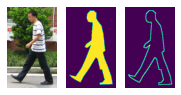

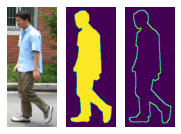

In [230]:
import matplotlib.pyplot as plt


extended_boxes, extended_images, extended_masks, extended_edges = load_images_masks_and_edges_from_path(
    train_imgs_paths[0], train_masks_paths[0], 12
)


for image, mask, edge in zip(extended_images, extended_masks, extended_edges):
    plt.figure(figsize=(3, 9))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(edge)
    plt.axis('off')
    plt.show()

Dataset loading:

In [231]:
def load_data_from_paths(img_paths, mask_paths):
    extended_boxes, extended_images, extended_masks, extended_edges = [], [], [], []
    for img_path, mask_path in zip(img_paths, mask_paths):
        new_boxes, new_images, new_masks, new_edges = load_images_masks_and_edges_from_path(
            img_path, mask_path,
        )
        extended_boxes.extend(new_boxes)
        extended_images.extend(new_images)
        extended_masks.extend(new_masks)
        extended_edges.extend(new_edges)
    return extended_boxes, extended_images, extended_masks, extended_edges


train_boxes, train_images, train_masks, train_edges = load_data_from_paths(
    img_paths=train_imgs_paths,
    mask_paths=train_masks_paths,
)


val_boxes, val_images, val_masks, val_edges = load_data_from_paths(
    img_paths=val_imgs_paths,
    mask_paths=val_masks_paths,
)


test_boxes, test_images, test_masks, test_edges = load_data_from_paths(
    img_paths=test_imgs_paths,
    mask_paths=test_masks_paths,
)

Dataset transformations:

In [232]:
from typing import List, Tuple, Dict, Optional, Union

import torch
import torchvision
from torch import nn, Tensor
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T, InterpolationMode

from numpy import ndarray

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask, edge):
        for t in self.transforms:
            image, mask, edge = t(image, mask, edge)
        return image, mask, edge


# Implement a Random Horizontal Flip on triple (image, mask, edge)
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def __init__(self, p=0.5):
        super(RandomHorizontalFlip, self).__init__()
        self.p = p
        
    def forward(
            self, 
            image: Tensor, 
            mask: Tensor, 
            edge: Tensor
    ) -> Tuple[Tensor, Tensor, Tensor]:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            mask = F.hflip(mask)
            edge = F.hflip(edge)
        return image, mask, edge

class ConvertImageDtype(nn.Module):
    def __init__(self, dtype: torch.dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(
            self, 
            image: Tensor,
            mask: Tensor, 
            edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        image = F.convert_image_dtype(image, self.dtype)
        return image, mask.to(torch.float32), edge.to(torch.float32)


# EfficientNet Normalization function
class Normalize(nn.Module):
    def __init__(self):
        super(Normalize, self).__init__()
        self.normalizer = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        return self.normalizer(image), mask, edge


class ToNumpy(nn.Module):
    def __init__(self):
        super(ToNumpy, self).__init__()

    def forward(
        self, 
        image: ndarray,
        mask: ndarray, 
        edge: ndarray,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        return (
            torch.from_numpy(image.astype('float32').transpose([2, 0, 1])) / 255.0,
            torch.from_numpy(mask),
            torch.from_numpy(edge),
        )


# Implement resizing image -> (128, 128), edge -> (64, 64), mask -> (64, 64)
class Upsample(nn.Module):
    def __init__(self, resized_image=128, resized_edge=64, resized_mask=64):
        super(Upsample, self).__init__()
        self.resized_image = (resized_image, resized_image)
        self.resized_edge = (resized_edge, resized_edge)
        self.resized_mask = (resized_mask, resized_mask)
    
    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        image = F.resize(image, self.resized_image)
        # F.resize requires (C, H, W) not (H, W) like in masks case
        mask = F.resize(mask.unsqueeze(0), self.resized_mask)
        edge = F.resize(edge.unsqueeze(0), self.resized_edge)

        return image, mask, edge

# TODO: implement two more transformations (e.g., rotations, color jitter, etc.)
def get_random_value(value_range: List[float]) -> float:
    return float(torch.empty(1).uniform_(
                value_range[0], 
                value_range[1]).item())


class RandomRotation(nn.Module):
    def __init__(self, degrees_range: int):
        super(RandomRotation, self).__init__()

        degrees_range = float(degrees_range)
        self.degrees_range = [-degrees_range, degrees_range]

    @staticmethod
    def get_angle(degrees: List[float]):
        return get_random_value(degrees)

    def forward(
        self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        angle = self.get_angle(self.degrees_range)
        
        image = F.rotate(image, angle)
        mask = F.rotate(mask, angle)
        edge = F.rotate(edge, angle)
        
        return image, mask, edge


class ColorJitter(T.ColorJitter):
    def forward(self, 
        image: Tensor,
        mask: Tensor, 
        edge: Tensor,
    ) -> Tuple[Tensor, Tensor, Tensor]:
        """
        Args:
            image (PIL Image or Tensor): Input image.

        Returns:
            PIL Image or Tensor: Color jittered image.
        """
        fn_idx, brightness_factor, contrast_factor, saturation_factor, hue_factor = self.get_params(
            self.brightness, self.contrast, self.saturation, self.hue
        )

        for fn_id in fn_idx:
            if fn_id == 0 and brightness_factor is not None:
                image = F.adjust_brightness(image, brightness_factor)
            elif fn_id == 1 and contrast_factor is not None:
                image = F.adjust_contrast(image, contrast_factor)
            elif fn_id == 2 and saturation_factor is not None:
                image = F.adjust_saturation(image, saturation_factor)
            elif fn_id == 3 and hue_factor is not None:
                image = F.adjust_hue(image, hue_factor)

        return image, mask, edge

Torch Datasets creation:

In [233]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        images,
        masks,
        edges,
        transforms,
    ):
        self.transforms = transforms
        self.images = images
        self.masks = masks
        self.edges = edges

    def __getitem__(self, idx):
        return self.transforms(
            self.images[idx],
            self.masks[idx], 
            self.edges[idx],
        )

    def __len__(self):
        return len(self.images)

# Extend this list with at least two additional transformations
train_transform = Compose(
    [
        ToNumpy(),
        ConvertImageDtype(torch.float32),
        Normalize(),
        RandomHorizontalFlip(),
        Upsample(),
        RandomRotation(degrees_range=15),
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ]
)

val_transform = Compose(
    [
        ToNumpy(),
        ConvertImageDtype(torch.float32),
        Normalize(),
        Upsample(),
    ]
)

# This should remain the same.
test_transform = Compose(
    [
        ToNumpy(),
        ConvertImageDtype(torch.float32),
        Normalize(),
        Upsample(),
    ]
)


train_dataset = PennFudanDataset(
    images=train_images,
    masks=train_masks,
    edges=train_edges,
    transforms=train_transform,
)

val_dataset = PennFudanDataset(
    images=val_images,
    masks=val_masks,
    edges=val_edges,
    transforms=test_transform,
)

test_dataset = PennFudanDataset(
    images=test_images,
    masks=test_masks,
    edges=test_edges,
    transforms=test_transform,
)

In [234]:
def show_masks(img, mask, edge, size=30):
    fig, ax = plt.subplots(1, 3, figsize=(size, size))

    ax[0].imshow(img.squeeze(0).permute(1, 2, 0))
    ax[1].imshow(mask.squeeze(0))
    ax[2].imshow(edge.squeeze(0))

    return fig, ax

torch.Size([3, 128, 128]) torch.Size([1, 64, 64]) torch.Size([1, 64, 64])
torch.Size([3, 128, 128]) torch.Size([1, 64, 64]) torch.Size([1, 64, 64])


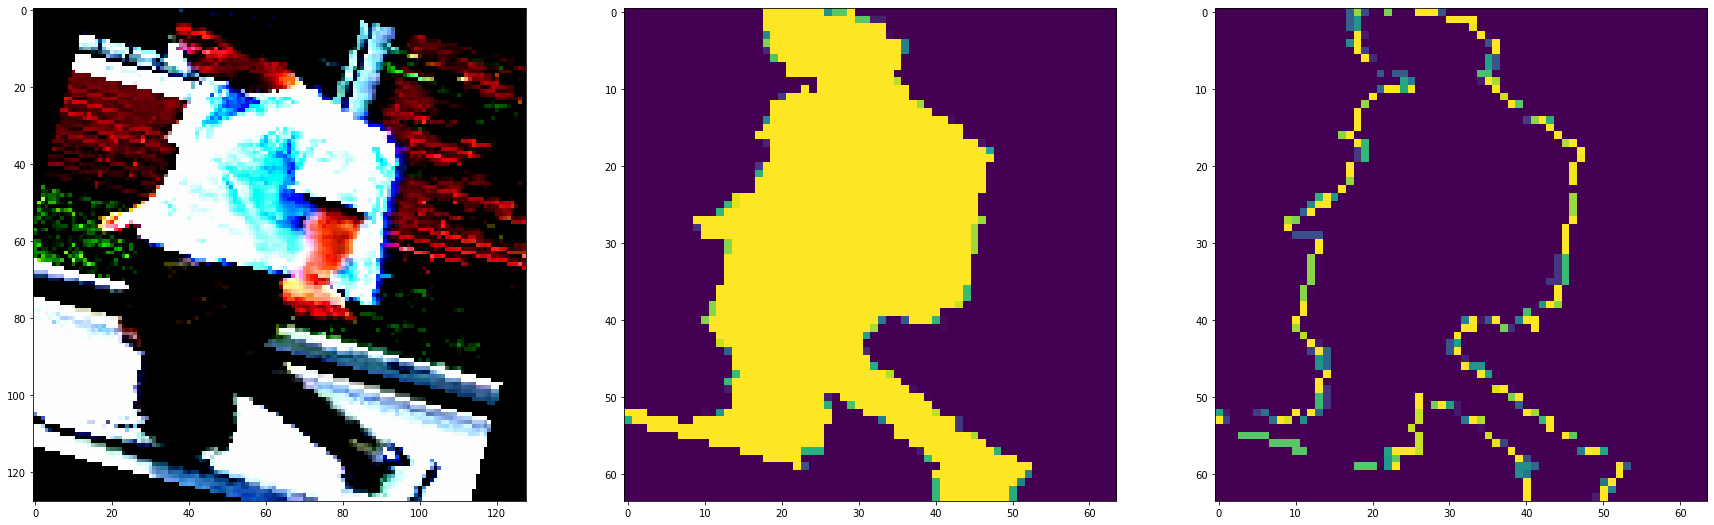

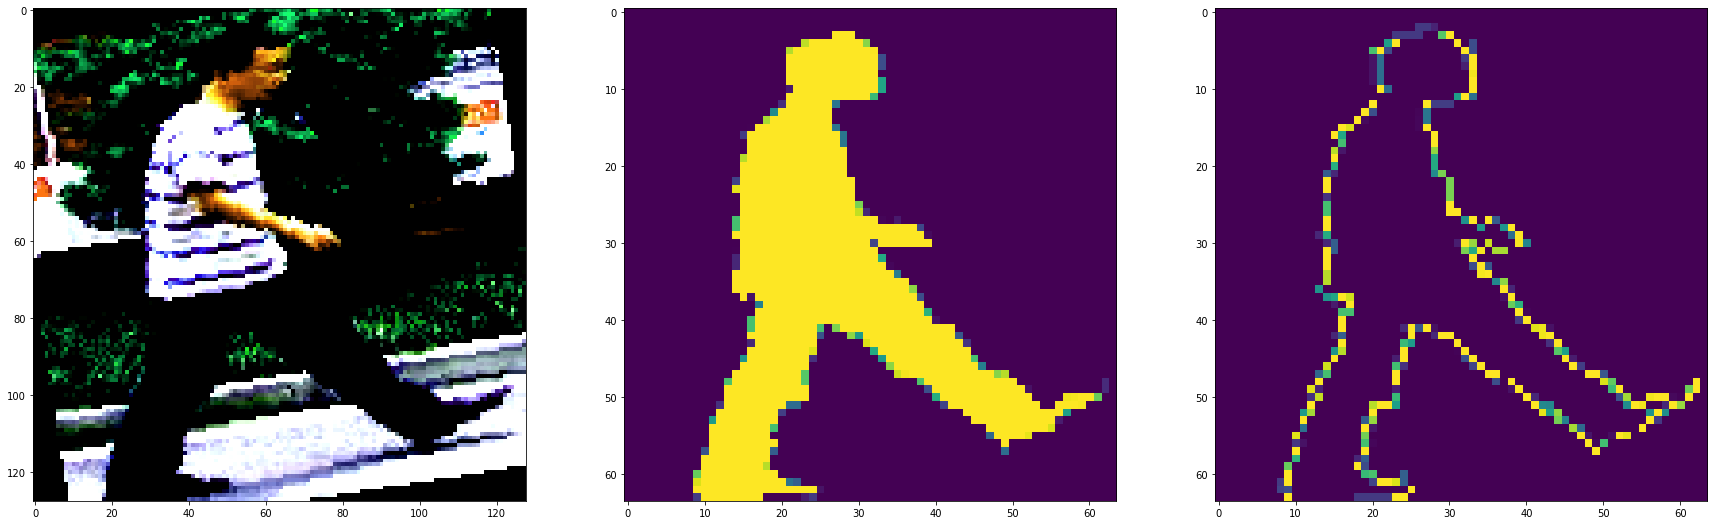

In [235]:
test_img1, test_mask1, test_edge1 = train_dataset[1]
print(test_img1.shape, test_mask1.shape, test_edge1.shape)
show_masks(test_img1, test_mask1, test_edge1)

test_img2, test_mask2, test_edge2 = train_dataset[0]
print(test_img2.shape, test_mask2.shape, test_edge2.shape)
show_masks(test_img2, test_mask2, test_edge2)

plt.show()

IOU implementation:

In [236]:
def iou(y_true: Tensor, y_pred: Tensor, threshold: float = 0.0, apply_sigmoid: bool = False):
    """
    y_true and y_pred shape: (*, 1, 64, 64)
    """
    # TODO: implement
    if apply_sigmoid:
        y_pred = torch.sigmoid(y_pred)

    if threshold > 0:
        y_pred = y_pred >= threshold

    intersection = torch.logical_and(y_true, y_pred)
    sum = torch.logical_or(y_true, y_pred)

    batch_size = y_pred.shape[0] if len(y_pred.shape) == 4 else 1
    ious = [
            torch.count_nonzero(intersection[idx])/torch.count_nonzero(sum[idx]) 
            for idx in range(batch_size) # for each mask in batch
            ]

    return torch.stack(ious)

In [237]:
print(iou(test_mask1, test_mask1))
print(iou(test_mask1, test_mask2))
print(iou(test_edge1, test_edge2))

tensor([1.])
tensor([0.4048])
tensor([0.0581])


# Note on using `efficientnet_pytorch`

The code below shows how to use `efficientnet_pytorch` to extract intermediate layers from an `efficient_net_model`:

```
!pip install efficientnet_pytorch


from efficientnet_pytorch import EfficientNet

EFFICIENT_NET_MODEL_NAME = 'efficientnet-b0'
model = EfficientNet.from_pretrained(EFFICIENT_NET_MODEL_NAME)
test_tensor = torch.tensor(np.random.normal(size=(1, 3, 128, 128)).astype('float32'))
intermediate_outputs_dict = model.extract_endpoints(test_tensor)
ilustrating_dict = {
    key_: intermediate_outputs_dict[key_].shape
    for key_ in intermediate_outputs_dict
}
print(ilustrating_dict)

Output:
{
  'reduction_1': torch.Size([1, 16, 64, 64]), 
  'reduction_2': torch.Size([1, 24, 32, 32]), 
  'reduction_3': torch.Size([1, 40, 16, 16]), 
  'reduction_4': torch.Size([1, 112, 8, 8]), 
  'reduction_5': torch.Size([1, 320, 4, 4]), 
  'reduction_6': torch.Size([1, 1280, 4, 4]),
}
```

One can obviously use other implementations of an `EfficientNet` architectures.

## Model implementation:

In [238]:
!pip install efficientnet_pytorch

In [239]:
from efficientnet_pytorch import EfficientNet


DEVICE = 'cuda'


class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise_conv = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, 
            stride=1, padding=1, groups=in_channels, bias=False
        )
        self.pointwise_conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1
        )

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x


class Head(nn.Module):
    # This module should accept either:
    # - output from the final BiFPN Block,
    # - outputs from all BiFPN blocks,
    # - all of above plus backbone outputs
    # And output tensor of shape (*, 1, 64, 64) - the final prediction output 
    def __init__(self, in_channels: int = 64, depth=3):
        super(Head, self).__init__()
        layers = []
        for i in range(depth):
            if i == depth-1:
                layers.append(
                    nn.Conv2d(int(in_channels*2**-i), 1, kernel_size=3, padding=1)
                )
            else:
                layers.append(
                    self.get_layer(int(in_channels*2**-i))
                )
        self.layers = nn.ModuleList(layers)

    @staticmethod
    def get_layer(in_channels: int):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels//2),
            nn.SiLU()
        )
    
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x


class FPNModule(nn.Module):
    # I assume that this won't be first layer after backbone and channels
    # will be already fixed to fpn_channels
    def __init__(self, fpn_channels: int = 64, inputs_amount: int = 5, epsilon=1e-4):
        super(FPNModule, self).__init__()
        self.epsilon = epsilon
        self.fpn_channels = fpn_channels
        
        upsamplers = []
        td_convs = []
        upsamplers_weights = []

        # there is inputs_amount-1 of upsample|downsample operations
        for _ in range(inputs_amount-1):
            upsamplers.append(
                nn.UpsamplingNearest2d(scale_factor=2)
            )
            td_convs.append(
                nn.Sequential(
                    DepthwiseSeparableConv2d(self.fpn_channels, self.fpn_channels),
                    nn.BatchNorm2d(self.fpn_channels),
                    nn.SiLU()
                )
            )
            upsamplers_weights.append(
                nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
            )
        
        self.upsamplers = nn.ModuleList(upsamplers) # top-down e.q. p7_to_p6 - p4_to_p3
        self.td_convs = nn.ModuleList(td_convs) # top-down e.q. p7_to_p6 - p4_to_p3
        self.upsamplers_weights = nn.ParameterList(upsamplers_weights) # top-down has two parameters: w1, w2

    def forward(self, inputs: List[Tensor]):
        """
        Inputs should be arranged in bottom-up manner.
        I.e. decreasing resolution.
        """
        # feature map with highest resolution
        prev_td_node = inputs.pop()
        # no processing is performed
        output = [prev_td_node]

        for idx, in_node in enumerate(inputs[::-1]):
            prev_td_node = self.upsamplers[idx](prev_td_node)
            w1, w2 = nn.functional.relu(self.upsamplers_weights[idx])
            td_node = self.td_convs[idx](
                (w1*in_node + w2*prev_td_node) / (w1+w2+self.epsilon)
            )
            prev_td_node = td_node
            output.append(prev_td_node)
        
        # output is also in bottom-up manner
        return output[::-1]


class BiFPNModule(torch.nn.Module):
    # This module should accepts list of tensors from different levels 
    # (e.g., from a backbone or a previous BiFPN block) and first 
    # applies a convolution with a fixed number of channels to each tensor and
    # then perform down and up passes to obtain new feature levels.
    # When one combines outputs from different passes remember about appropriate
    # fusion strategy (tensor-wise, channel-wise or pixel-wise).
    def __init__(self, bifpn_channels: int = 64, inputs_amount: int = 5, initial_input_channels: List[int] = [], epsilon=1e-4):
        super(BiFPNModule, self).__init__()
        self.epsilon = epsilon

        self.bifpn_channels = bifpn_channels
        self.inputs_amount = inputs_amount

        self.initial_module = bool(len(initial_input_channels))

        if self.initial_module:
            channel_fixers = [] # top-down e.q. p7 - p3 
            # we start from the deepest feature map, that's why we inverse initial_input_channels
            for in_channels in initial_input_channels[::-1]:
                channel_fixers.append(
                    nn.Sequential(
                        nn.Conv2d(in_channels, self.bifpn_channels, kernel_size = 1), 
                        nn.BatchNorm2d(self.bifpn_channels)
                        )
                    )
            # initial input down channel
            self.channel_fixers = nn.ModuleList(channel_fixers) # top-down e.q. p7 - p3 

        # feature map resizeing
        upsamplers = [] # top-down e.q. p7_to_p6 - p4_to_p3
        downsamplers = [] # bottom-up e.q.  p3_to_p4 - p6_to_p7

        # feature map processing
        td_convs = [] # top-down e.q. p7_to_p6 - p4_to_p3
        bu_convs = [] # bottom-up e.q.  p3_to_p4 - p6_to_p7

        # weights for each node input
        upsample_weights = [] # top-dwon has two parameters: w1, w2
        downsample_weights = [] # bottom-up has three parameters: w'1, w'2, w'3

        # there is inputs_amount-1 of upsample|downsample operations
        for i in range(self.inputs_amount-1):
            upsamplers.append(
                nn.UpsamplingNearest2d(scale_factor=2)
                )
            td_convs.append(
                nn.Sequential(
                    # we can also use normal convolution which would be slower
                    DepthwiseSeparableConv2d(self.bifpn_channels, self.bifpn_channels),
                    # nn.Conv2d(
                    #     self.bifpn_channels, self.bifpn_channels, 
                    #     kernel_size = 3, padding=1
                    # ),
                    nn.BatchNorm2d(self.bifpn_channels),
                    nn.SiLU(),
                )
            )
            upsample_weights.append(
                nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
            )

            # we can also use maxpool2d for downsampling but in PANet paper they used convolution
            downsamplers.append(
                nn.Conv2d(
                    self.bifpn_channels, self.bifpn_channels, 
                    kernel_size = 3, stride = 2, padding=1
                    )
            )

            # downsamplers.append(
            #     nn.MaxPool2d(
            #         kernel_size = 3, stride = 2, padding=1
            #         )
            # )

            bu_convs.append(
                nn.Sequential(
                    # we can also use normal convolution which would be slower
                    DepthwiseSeparableConv2d(self.bifpn_channels, self.bifpn_channels),
                    # nn.Conv2d(
                    #     self.bifpn_channels, self.bifpn_channels, 
                    #     kernel_size = 3, padding=1
                    # ),
                    nn.BatchNorm2d(self.bifpn_channels),
                    nn.SiLU(),
                )
            )
            if i == self.inputs_amount-2: # last node in bottom-up layer will have only two inputs
                downsample_weights.append(
                    nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
                )
            else:
                downsample_weights.append(
                    nn.Parameter(torch.ones(3, dtype=torch.float32), requires_grad=True)
                )

        # feature map resizeing
        self.upsamplers = nn.ModuleList(upsamplers) # top-down e.q. p7_to_p6 - p4_to_p3
        self.downsamplers = nn.ModuleList(downsamplers) # bottom-up e.q.  p3_to_p4 - p6_to_p7

        # feature map processing
        self.td_convs = nn.ModuleList(td_convs) # top-down e.q. p7_to_p6 - p4_to_p3
        self.bu_convs = nn.ModuleList(bu_convs) # bottom-up e.q.  p3_to_p4 - p6_to_p7

        # weights for each node input
        self.upsample_weights = nn.ParameterList(upsample_weights) # top-down has two parameters: w1, w2
        self.downsample_weights = nn.ParameterList(downsample_weights) # bottom-up has three parameters: w'1, w'2, w'3

    def forward(self, inputs: List[Tensor]):
        """
        Inputs should be arranged in bottom-top manner.
        I.e. decreasing resolution.
        """
        prev_td_node = None # previously calculated node on td layer
        bp_layer = [] # list of lists containing nodes that will be added together

        # inputs are increasing in depth but we want to go from the 
        # deepest feature map to shallowest one, that's why we invert inputs
        for idx, in_node in enumerate(inputs[::-1]):
            
            # perform down channeling on input if it is initial bifpn_layers module
            if self.initial_module:
                in_node = self.channel_fixers[idx](in_node)

            if idx == 0:
                # add in_node to be later summed in bottom-up layer
                bp_layer.append([in_node])
                # compute upsampled input for first node in top-down layer
                prev_td_node = self.upsamplers[idx](in_node)
            elif idx == len(inputs)-1:
                # calculate weighted feature maps sum
                w1, w2 = nn.functional.relu(self.upsample_weights[idx-1])
                td_node = self.td_convs[idx-1](
                    (w1*in_node + w2*prev_td_node) / (w1+w2+self.epsilon)
                )
                # add first node in bottom up layer
                bp_layer.append([td_node])
            else:
                # calculate weighted feature maps sum
                w1, w2 = nn.functional.relu(self.upsample_weights[idx-1])
                td_node = self.td_convs[idx-1](
                    (w1*in_node + w2*prev_td_node) / (w1+w2+self.epsilon)
                )
                # add nodes to be later summed in bottom-up layer
                bp_layer.append([in_node, td_node])
                # compute upsampled input for next node in top-down layer
                prev_td_node = self.upsamplers[idx](td_node)

        # first node in bottom-up layer
        prev_out_node = bp_layer.pop()[0]
        # push it to output
        output = [prev_out_node]

        # node lists were added in top-down manner so we invert them to compute
        # in bottom-up manner, we also skip first element, because it has been handled already.
        for idx, node_list in enumerate(bp_layer[::-1]):
            # downsample previous out node
            prev_out_node = self.downsamplers[idx](prev_out_node)
            
            # calculate weighted feature maps sum
            if idx == self.inputs_amount-2: # last node in bottom-up layer
                w1, w3 = nn.functional.relu(self.downsample_weights[idx])
                # only one node waiting to be added in the last step
                in_node = node_list[0]
                out_node = self.bu_convs[idx-1](
                        (w1*in_node + w3*prev_out_node) / (w1+w3+self.epsilon)
                    )
            else:
                w1, w2, w3 = nn.functional.relu(self.downsample_weights[idx])
                in_node, td_node = node_list
                out_node = self.bu_convs[idx-1](
                        (w1*in_node + w2*td_node + w3*prev_out_node) / (w1+w2+w3+self.epsilon)
                    )
            output.append(out_node)

        # output is also in bottom-up manner
        return output


class EfficientDetModule(torch.nn.Module):
    # Combine:
    # - EfficientNet backbone,
    # - multiple BiFPN blocks,
    # - two heads - mask prediction and edge prediction ones,
    # to obtain a final output for an edge aware person segmentation.
    def __init__(
        self, 
        bifpn_channels: int = 64,
        bifpn_depth: int = 3, 
        head_depth: int = 3
        ):
        super(EfficientDetModule, self).__init__()

        self.bifpn_channels = bifpn_channels # amount of BiFPN channels
        self.bifpn_depth = bifpn_depth # amount of BiFPN blocks
        self.head_depth = head_depth # amount of layers in head

        self.backbone = EfficientNet.from_pretrained("efficientnet-b0")
        # channel amounts of backbone outputs
        initial_input_channels = [16, 24, 40, 112, 320, 1280]
        # we skip fifth layer, because it has the same resolution as sixth but less channels
        self.chosen_intermediate_layers = [0, 1, 2, 3, 5]
        initial_input_channels = [
                                  initial_input_channels[i] 
                                  for i in self.chosen_intermediate_layers
                                  ]

        # initial BiFPN layer has to set channel amounts to self.bifpn_depth
        bifpn_layers = [
                 BiFPNModule(
                     bifpn_channels=self.bifpn_channels, 
                     inputs_amount=len(initial_input_channels), 
                     initial_input_channels=initial_input_channels
                     )
        ]
        # the rest of BiFPN layers
        for _ in range(self.bifpn_depth-1):
            bifpn_layers.append(
                BiFPNModule(
                    bifpn_channels=self.bifpn_channels, 
                    inputs_amount=len(initial_input_channels)
                    )
                )

        self.bifpn_layers = nn.ModuleList(bifpn_layers)

        # additional fpn layer to merge outputs of final bifpn module
        self.fpn_layer = FPNModule(
            fpn_channels=self.bifpn_channels, 
            inputs_amount=len(initial_input_channels)
        )
        # two heads: person segmentation and edge detection
        self.heads = nn.ModuleList(
            [
             Head(in_channels=self.bifpn_channels, depth=self.head_depth) 
             for _ in range(2)
             ]
        )

    def get_non_backbone_params(self):
        # This function might be useful for a training of only BiFPNs and heads
        return self.bifpn_layers.parameters(), self.fpn_layer.parameters(), self.heads.parameters()

    def get_backbone_params(self):
        # This function might be useful for a backbone finetunning.
        return self.backbone.parameters()
    
    def forward(self, x):
        intermediate_outputs = list(self.backbone.extract_endpoints(x).values())

        intermediate_outputs = [
                                intermediate_outputs[i] 
                                for i in self.chosen_intermediate_layers
                                ]

        for bifpn_layer in self.bifpn_layers:
            intermediate_outputs = bifpn_layer(intermediate_outputs)

        intermediate_outputs = self.fpn_layer(intermediate_outputs)

        output_layer = intermediate_outputs[0] # resolution: 64x64

        mask_output = self.heads[0](output_layer)
        edge_output = self.heads[1](output_layer)

        return mask_output, edge_output

Loader preparation:

In [240]:
# Adjust
BATCH_SIZE = 16


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True,
)


val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=len(val_dataset)//2, # I reduced this number, because gpu memory was exceeded
    num_workers=2,
    pin_memory=True,
)


test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=len(test_dataset)//2, # I reduced this number, because gpu memory was exceeded
    num_workers=2,
    pin_memory=True,
)

Model and optimizer preparation:

In [241]:
# Adjust
ed = EfficientDetModule(head_depth=3).to(device=DEVICE)

# Select optimizer
optimizer = torch.optim.Adam(ed.parameters(), lr=0.005)

Loaded pretrained weights for efficientnet-b0


# Example training loop:

Modify it to:
- analyze multiple `LAMBDA` values,
- [OPTIONAL] train a BiFPNs and heads first and then fine-tune the backbone.

In [242]:
# Adjust
EPOCHS = 40

LAMBDA = 0.01
IOU_THRESHOLD = 0.3 # tested it manually bellow
# mask_pred seems to have higher values than edge_pred


# this function should return a triple (full_loss, mask_loss, edge_loss)
def loss_function(masks_pred, edges_pred, masks_gt, edges_gt, lambda_=LAMBDA):
    """
    I wanted to use BCE with logits because it is written in pytorch documentation
    that this way is more numerically stable than using sigmoid on output and
    then BCE. I will explicitly use sigmoid when calculating IOU
    """
    mask_loss = nn.functional.binary_cross_entropy_with_logits(masks_pred, masks_gt)
    edge_loss = lambda_ * nn.functional.binary_cross_entropy_with_logits(edges_pred, edges_gt)
    full_loss = mask_loss + edge_loss

    return full_loss, mask_loss, edge_loss
    

for epoch in range(EPOCHS): 

    running_edge_loss = 0.0
    running_mask_loss = 0.0
    running_iou = 0.0 
    running_edge_iou = 0.0
    
    for i, data in enumerate(train_loader, 0):
        images, masks, edges = (data_col.to(DEVICE) for data_col in data)
        optimizer.zero_grad()
        masks_pred, edges_pred = ed(images)
        full_loss, mask_loss, edge_loss = loss_function(
            masks_pred,
            edges_pred,
            masks,
            edges,
        )

        iou_ = iou(masks, masks_pred, threshold=IOU_THRESHOLD, apply_sigmoid=True)
        edge_iou = iou(edges, edges_pred, threshold=IOU_THRESHOLD, apply_sigmoid=True)
        full_loss.backward()
        optimizer.step()

        # print statistics
        running_edge_loss += edge_loss.mean().item()
        running_mask_loss += mask_loss.mean().item()
        running_iou += iou_.mean().item() # iou returns (batch_size, C, H, W) so we should use mean
        running_edge_iou += edge_iou.mean().item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] '
                  f'edge loss: {running_edge_loss / 10:.3f}, '
                  f'mask loss: {running_mask_loss / 10:.3f}, '
                  f'running_iou {running_iou / 10:.3f}, '
                  f'edge iou {running_edge_iou / 10:.3f}.')
            running_edge_loss = 0.0
            running_mask_loss = 0.0
            running_iou = 0.0 
            running_edge_iou = 0.0
    
    # Test evaluation
    full_mask_loss = 0.0
    full_edge_loss = 0.0
    iou_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        images, masks, edges = (data_col.to(DEVICE) for data_col in data)
        masks_pred, edges_pred = ed(images)
        test_full_loss, test_mask_loss, test_edge_loss = loss_function(
            masks_pred,
            edges_pred,
            masks,
            edges,
        )
        test_iou_loss = iou(masks, masks_pred, threshold=IOU_THRESHOLD, apply_sigmoid=True)
        test_edge_iou = iou(edges, edges_pred, threshold=IOU_THRESHOLD, apply_sigmoid=True)

    print(f'[{epoch + 1}] '
          f'test edge loss: {test_mask_loss.mean():.3f}, '
          f'test mask loss: {test_edge_loss.mean():.3f}, '
          f'test iou loss {test_iou_loss.mean():.3f}, '
          f'test edge iou {test_edge_iou.mean():.3f}.') # I assume dividing by 10 is a mistake
        #   f'test edge iou {test_edge_iou.mean() / 10:.3f}.')


[1,    10] edge loss: 0.005, mask loss: 0.524, running_iou 0.504, edge iou 0.096.
[1] test edge loss: 0.205, test mask loss: 0.002, test iou loss 0.792, test edge iou 0.000.
[2,    10] edge loss: 0.002, mask loss: 0.287, running_iou 0.711, edge iou 0.000.
[2] test edge loss: 0.177, test mask loss: 0.002, test iou loss 0.840, test edge iou 0.012.
[3,    10] edge loss: 0.002, mask loss: 0.246, running_iou 0.759, edge iou 0.096.
[3] test edge loss: 0.140, test mask loss: 0.001, test iou loss 0.845, test edge iou 0.130.
[4,    10] edge loss: 0.002, mask loss: 0.228, running_iou 0.760, edge iou 0.159.
[4] test edge loss: 0.121, test mask loss: 0.001, test iou loss 0.863, test edge iou 0.214.
[5,    10] edge loss: 0.002, mask loss: 0.198, running_iou 0.788, edge iou 0.195.
[5] test edge loss: 0.119, test mask loss: 0.001, test iou loss 0.873, test edge iou 0.153.
[6,    10] edge loss: 0.002, mask loss: 0.195, running_iou 0.791, edge iou 0.203.
[6] test edge loss: 0.146, test mask loss: 0.001

In [260]:
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': ed.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'full_loss': full_loss,
            'test_mask_iou': 0.929,
            'test_edge_iou': 0.502
            }, "ed_E40_m929_e502")

# Simple visualisation

In [244]:
test_iter = iter(test_loader)
imgs, masks, edges = next(test_iter)
imgs, masks, edges = imgs.to(DEVICE), masks.to(DEVICE), edges.to(DEVICE)
masks_pred, edges_pred = ed(imgs)
masks_pred, edges_pred = torch.sigmoid(masks_pred), torch.sigmoid(edges_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


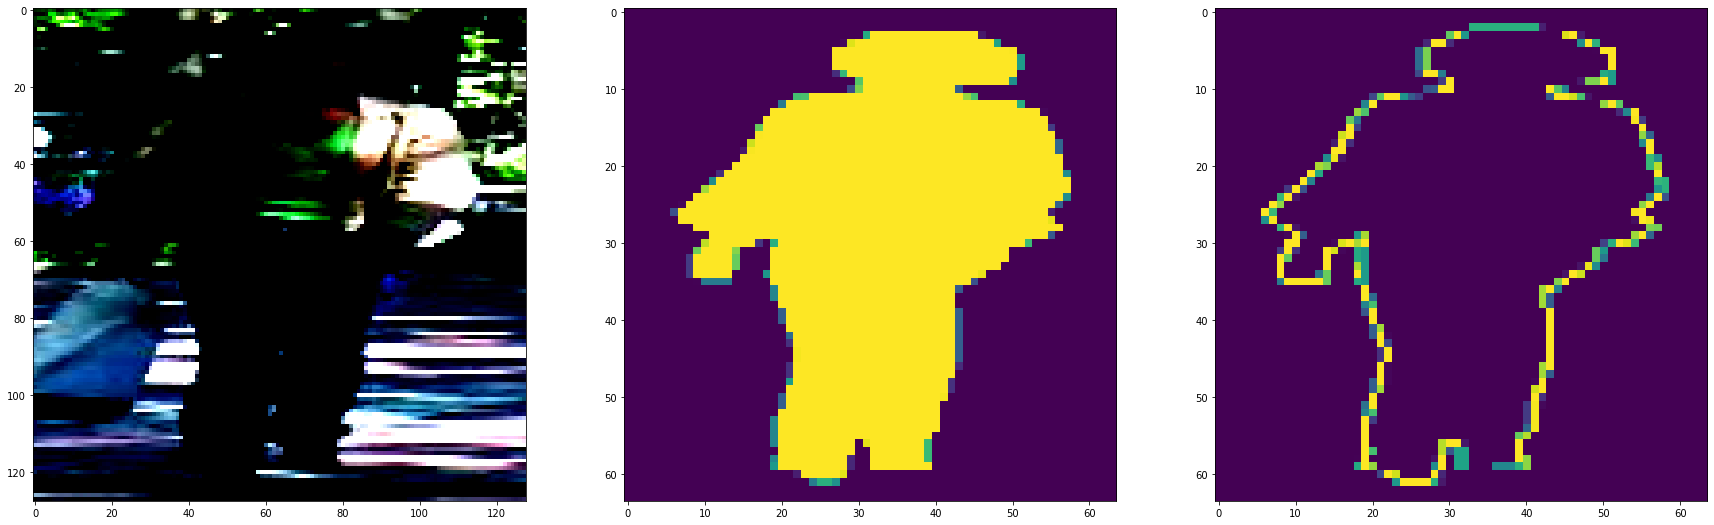

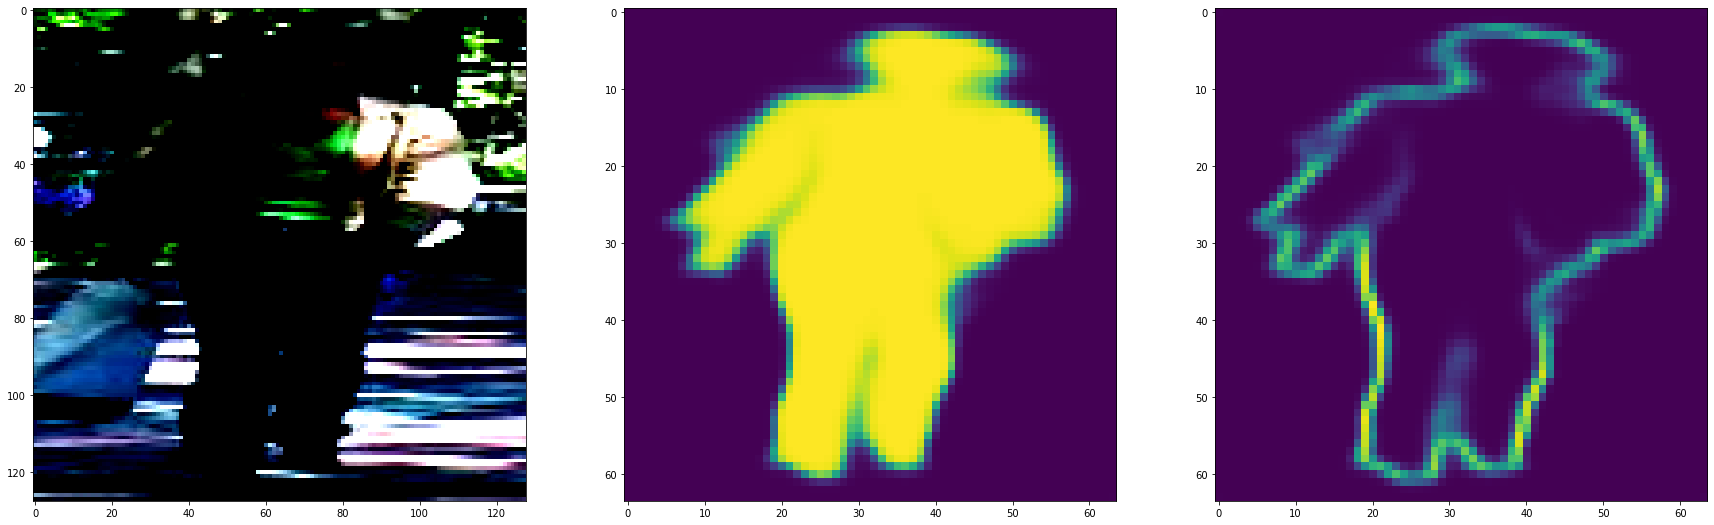

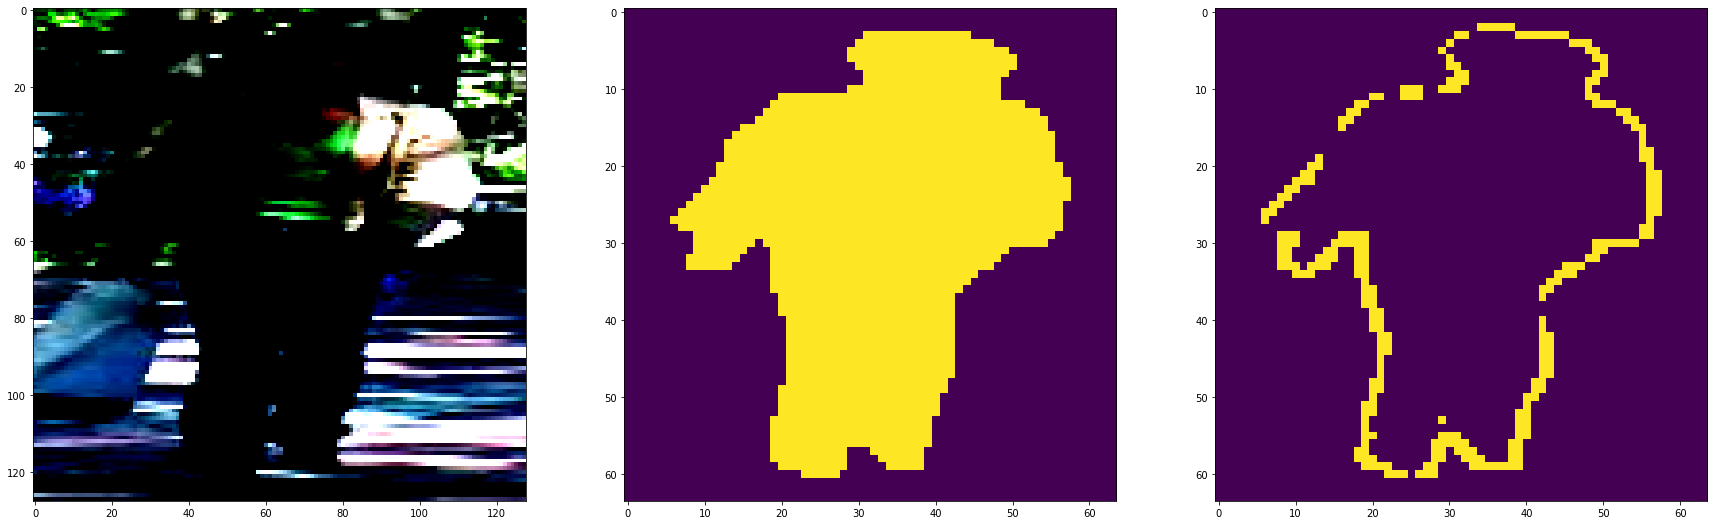

In [245]:
mask_threshold = 0.3
edge_threshold = 0.3

idx = 1

show_masks(imgs[idx].cpu(), masks[idx].cpu(), edges[idx].cpu())

show_masks(imgs[idx].cpu(), masks_pred[idx].detach().cpu(), edges_pred[idx].detach().cpu())

show_masks(
    imgs[idx].cpu(), masks_pred[idx].detach().cpu() >= mask_threshold, 
    edges_pred[idx].detach().cpu() >= edge_threshold
    )

plt.show()

# RAPORT

# Code for visualisation of extremes

In [246]:
def merge_batches(values, indecies):
    """Merges 2d tensor rows to 1d tensor with preserved indecies."""
    new_values = []
    new_indecies = []

    for i, row in enumerate(indecies):
        for j, el in enumerate(row):
            new_values.append(values[i][j].item())
            new_indecies.append((i, el.item()))

    return new_values, new_indecies

def get_extreme_examples(ious, n=5):
    sorted_ious_tensor, indecies_ious_tensor = torch.sort(ious)

    # take n highest ious and n lowest
    min_values, min_indecies = sorted_ious_tensor[:, :n], indecies_ious_tensor[:, :n]
    max_values, max_indecies = sorted_ious_tensor[:, -n:], indecies_ious_tensor[:, -n:]

    min_values, min_indecies = merge_batches(min_values, min_indecies)
    max_values, max_indecies = merge_batches(max_values, max_indecies)

    min_values, min_indecies = zip(*sorted(zip(min_values, min_indecies), key=lambda x: x[0])[:n])
    max_values, max_indecies = zip(*sorted(zip(max_values, max_indecies), key=lambda x: x[0])[-n:][::-1])

    return min_values, min_indecies, max_values, max_indecies

def print_out_extremes(indecies):
    for y, x in indecies:
        print(
            f"mask_iou: {MASK_IOUS[y][x]} edge_iou: {EDGE_IOUS[y][x]}"
        )

def visualise_extremes(indecies, use_threshold=True, size=10):
    for coord in indecies:
        y, x = coord
        gt_img, gt_mask, gt_edge = ALL_GT_IMGES[y][x], ALL_GT_MASKS[y][x], ALL_GT_EDGES[y][x]
        pred_mask, pred_edge = torch.sigmoid(ALL_PRED_MASKS[y][x]), torch.sigmoid(ALL_PRED_EDGES[y][x])
        show_masks(gt_img.cpu(), gt_mask.cpu(), gt_edge.cpu(), size=size)
        if use_threshold:
            pred_mask = pred_mask >= IOU_THRESHOLD
            pred_edge = pred_edge >= IOU_THRESHOLD
        show_masks(gt_img.cpu(), pred_mask.detach().cpu(), pred_edge.detach().cpu(), size=size)
    plt.show()

In [247]:
MASK_IOUS = []
EDGE_IOUS = []

ALL_GT_IMGES, ALL_GT_MASKS, ALL_GT_EDGES = [], [], []
ALL_PRED_MASKS, ALL_PRED_EDGES = [], []

# make predictions on test dataset for each batch
for idx, test_batch in enumerate(test_loader):
    imgs, masks, edges = test_batch
    imgs, masks, edges = imgs.to(DEVICE), masks.to(DEVICE), edges.to(DEVICE)
    
    ALL_GT_IMGES.append(imgs)
    ALL_GT_MASKS.append(masks)
    ALL_GT_EDGES.append(edges)

    masks_pred, edges_pred = ed(imgs)

    ALL_PRED_MASKS.append(masks_pred)
    ALL_PRED_EDGES.append(edges_pred)

    # calculate ious
    mask_iou = iou(masks, masks_pred, threshold=IOU_THRESHOLD, apply_sigmoid=True)
    edge_iou = iou(edges, masks_pred, threshold=IOU_THRESHOLD, apply_sigmoid=True)

    MASK_IOUS.append(mask_iou)
    EDGE_IOUS.append(edge_iou)

# stack iou tensors (i assume that each tensor has the same shape, this works for test_loader but not val_loader)
MASK_IOUS = torch.stack(MASK_IOUS)
EDGE_IOUS = torch.stack(EDGE_IOUS)

min_values_mask, min_indecies_mask, max_values_mask, max_indecies_mask = get_extreme_examples(MASK_IOUS)
min_values_edge, min_indecies_edge, max_values_edge, max_indecies_edge = get_extreme_examples(EDGE_IOUS)

# Mask_iou and edge_iou values of the best 5 mask predictions

In [248]:
print_out_extremes(max_indecies_mask)

mask_iou: 0.9508373737335205 edge_iou: 0.13904862105846405
mask_iou: 0.9404277205467224 edge_iou: 0.09674185514450073
mask_iou: 0.9392498731613159 edge_iou: 0.1148892343044281
mask_iou: 0.9385150671005249 edge_iou: 0.09537088871002197
mask_iou: 0.9362801313400269 edge_iou: 0.10173281282186508


# Mask_iou and edge_iou values of the worst 5 mask predictions

In [249]:
print_out_extremes(min_indecies_mask)

mask_iou: 0.5753012299537659 edge_iou: 0.11927788704633713
mask_iou: 0.7202472686767578 edge_iou: 0.12404287606477737
mask_iou: 0.7246145606040955 edge_iou: 0.11222339421510696
mask_iou: 0.7273324728012085 edge_iou: 0.059206247329711914
mask_iou: 0.7381350994110107 edge_iou: 0.1524122804403305


# Mask_iou and edge_iou values of the best 5 edge predictions

In [250]:
print_out_extremes(max_indecies_edge)

mask_iou: 0.8211488127708435 edge_iou: 0.23459120094776154
mask_iou: 0.7998790740966797 edge_iou: 0.2283419370651245
mask_iou: 0.7384859919548035 edge_iou: 0.20603272318840027
mask_iou: 0.8503184914588928 edge_iou: 0.19612590968608856
mask_iou: 0.8232526779174805 edge_iou: 0.15290102362632751


# Mask_iou and edge_iou values of the worst 5 edge predictions

In [251]:
print_out_extremes(min_indecies_edge)

mask_iou: 0.7273324728012085 edge_iou: 0.059206247329711914
mask_iou: 0.8872964382171631 edge_iou: 0.06692160665988922
mask_iou: 0.840691864490509 edge_iou: 0.08080336451530457
mask_iou: 0.7732934951782227 edge_iou: 0.08442871272563934
mask_iou: 0.8744915723800659 edge_iou: 0.09030303359031677


# Analiza korelacji ekstremalnych wartości mask iou i edge iou

Patrząc na wartości mask_iou, edge_iou i wizualizacje predykcji można stwierdzić, że predykcje posiadające niską wartość edge_iou generalnie mają też niską wartość mask_iou. Analogicznie wartości z wysokim edge_iou mają też generalnie wysokie mask_iou. W drugą stone co ciekawe nie widać specjalnie korelacji.

# Visualisation of the best 5 mask predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

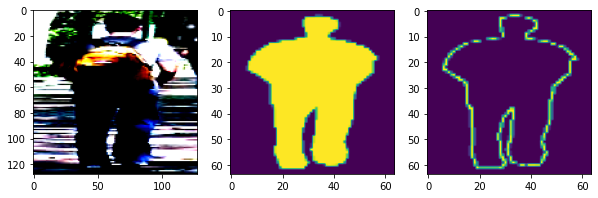

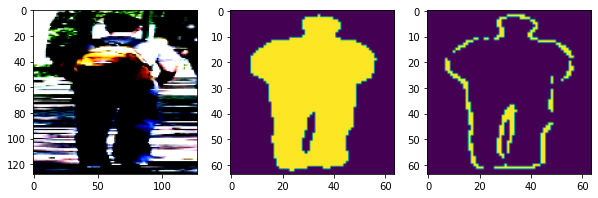

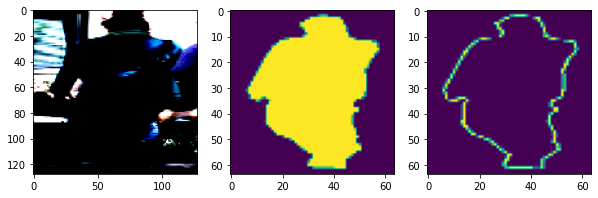

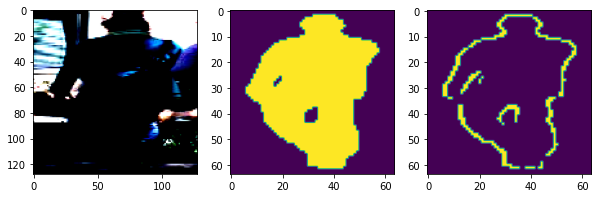

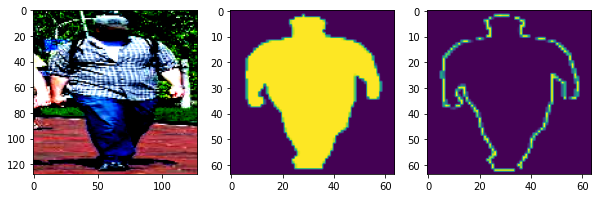

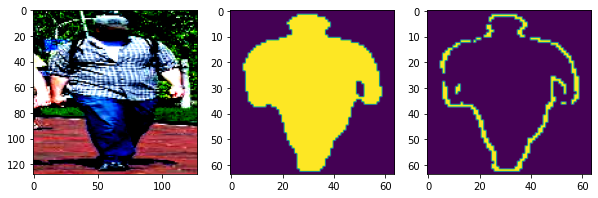

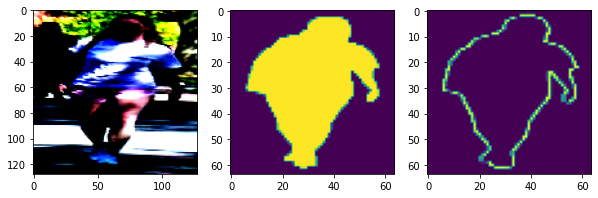

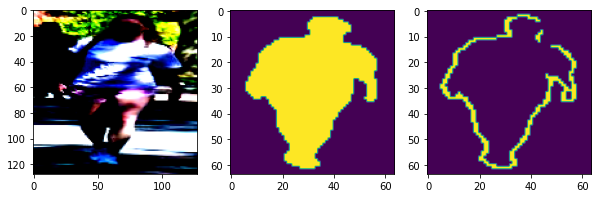

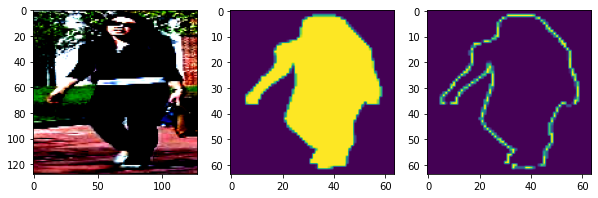

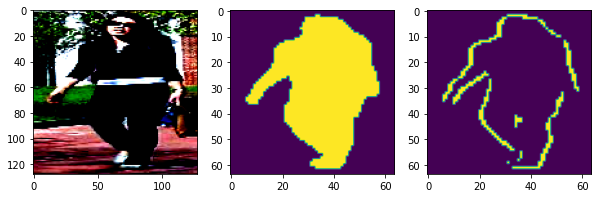

In [252]:
visualise_extremes(max_indecies_mask)

# Visualisation of the worst 5 mask predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

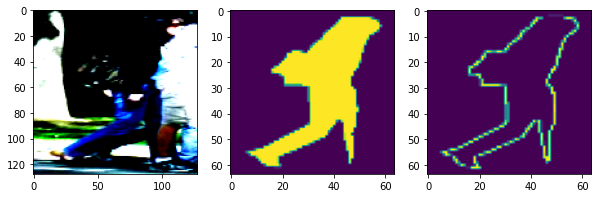

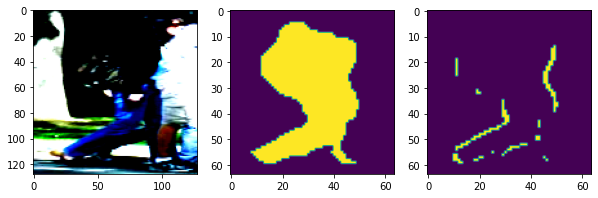

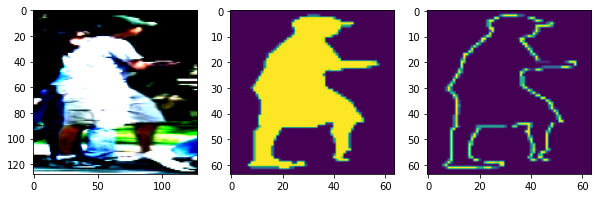

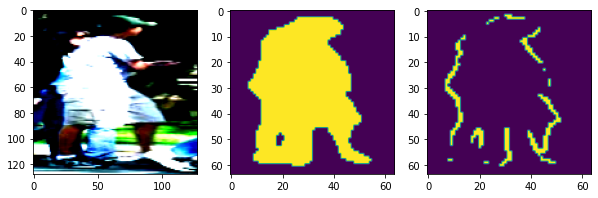

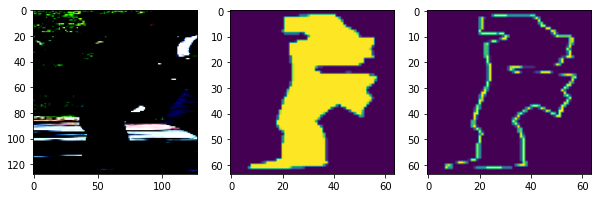

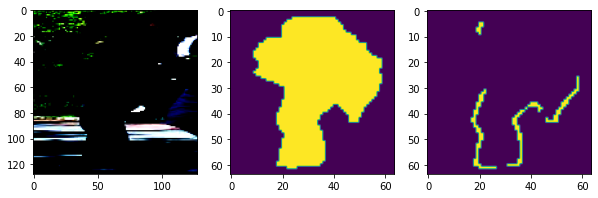

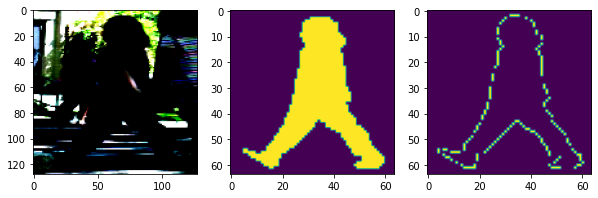

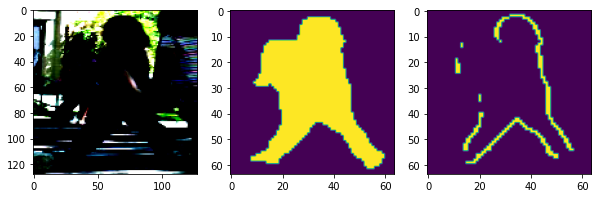

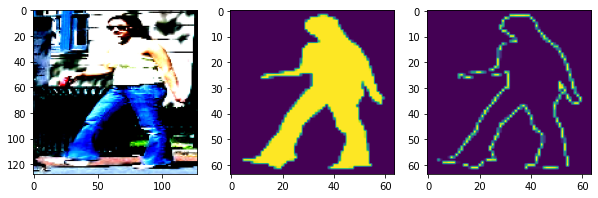

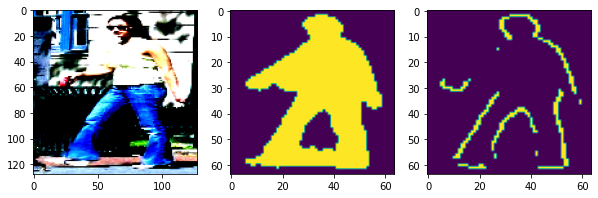

In [253]:
visualise_extremes(min_indecies_mask)

# Visualisation of the best 5 edge predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

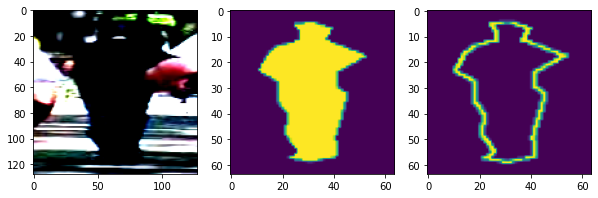

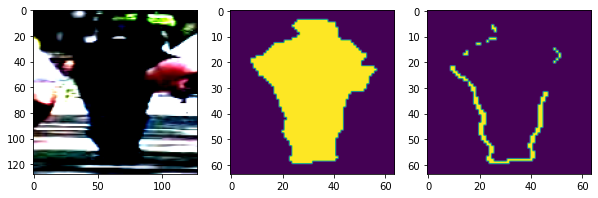

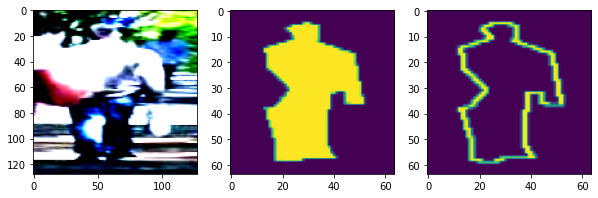

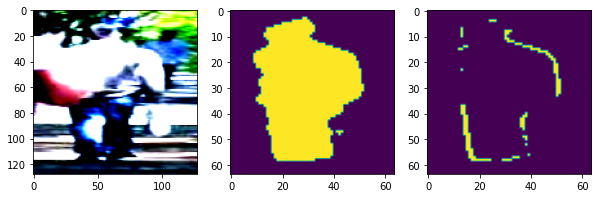

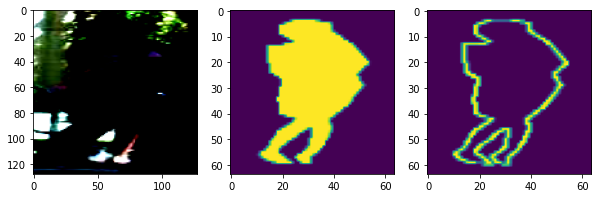

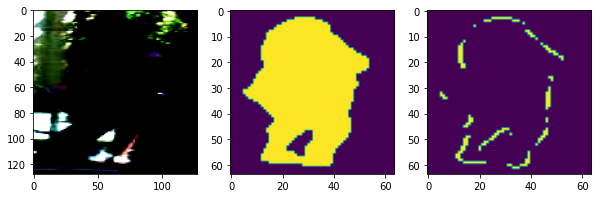

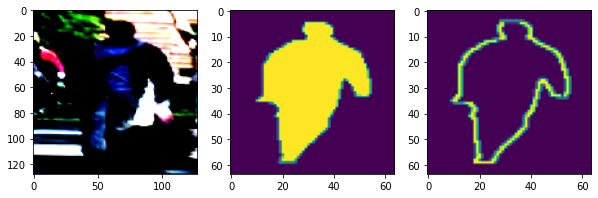

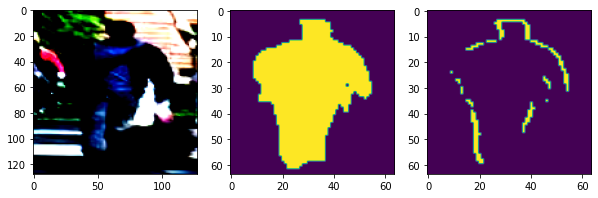

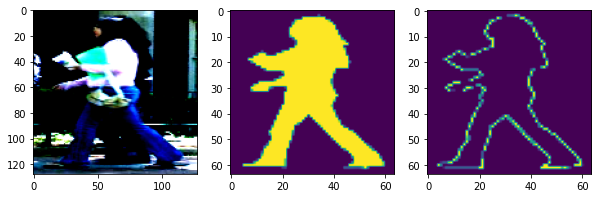

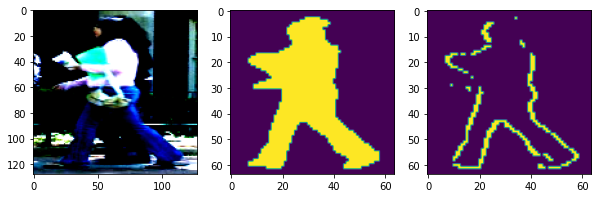

In [254]:
visualise_extremes(max_indecies_edge)

# Visualisation of the worst 5 edge predictions



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

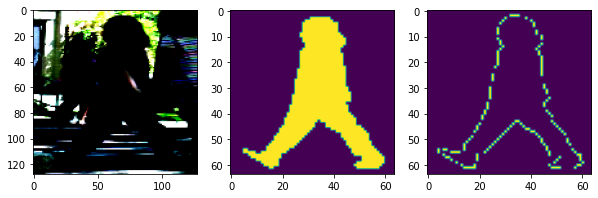

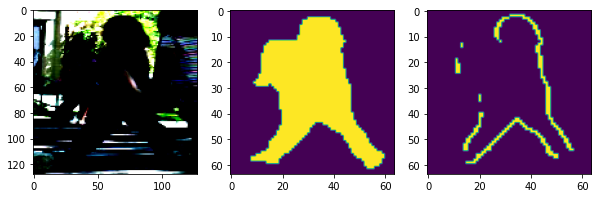

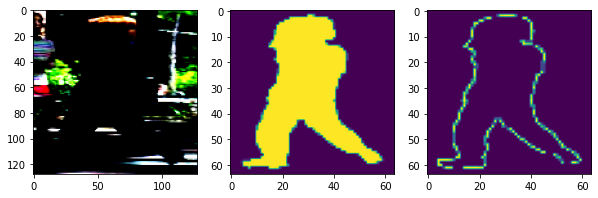

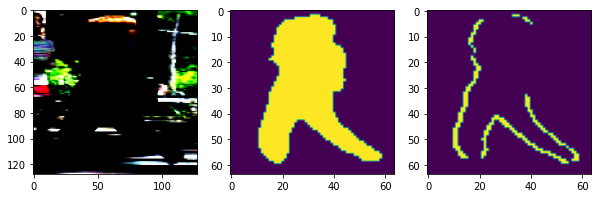

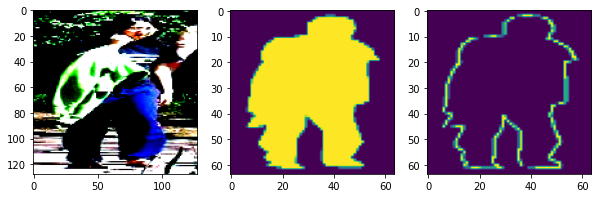

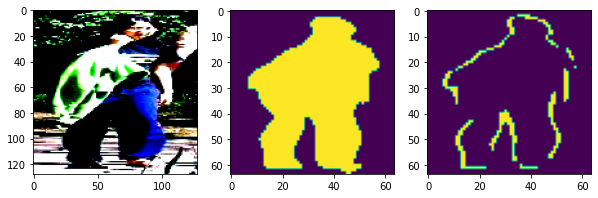

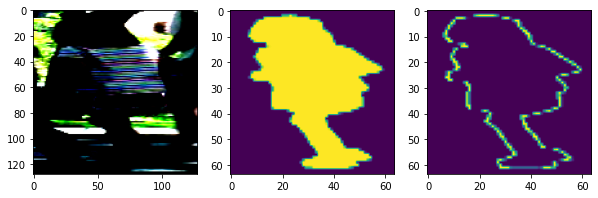

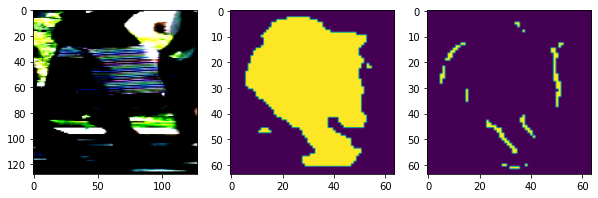

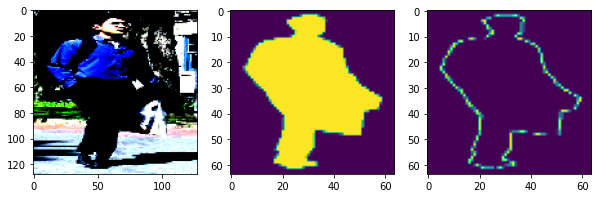

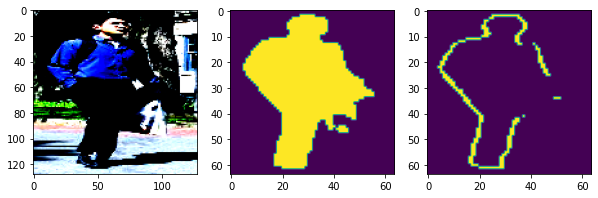

In [255]:
visualise_extremes(min_indecies_edge)

# Analiza wartości lambda

## lambda = 0
Spodzieamy się, że nasz model w ogóle nie będzie się uczył znajdowania krawędzi, ponieważ edge_loss stale będzie równe 0 i nic nie będzie poprawiane. Model będzie tylko segmentował ludzi.

Tak jak się spodziewaliśmy, model świetnie segmentuje ludzi. mask loss spadł do dość niskiej wartości, natomiast edge loss stale równy 0. Running_iou na poziomie około 0.9.

`[40,    10] edge loss: 0.000, mask loss: 0.114, running_iou 0.873, edge iou 0.084.`

`[40] test edge loss: 0.071, test mask loss: 0.000, test iou loss 0.918, test edge iou 0.079.`

Na wyjsciu edge detection head widzimy tylko pewien zarys tekstur człowieka. Prawdopodobnie dzieje się tak, dlatego, bo mamy pretrained backbone.

## lambda = 0.01
Zarówno edge loss jaki i mask loss spadły do niskich wartości, mask iou i edge iou są dobre.

`[40,    10] edge loss: 0.001, mask loss: 0.113, running_iou 0.876, edge iou 0.351.`

`[40] test edge loss: 0.070, test mask loss: 0.001, test iou loss 0.935, test edge iou 0.515.`

Edge iou jest pozornie mały, ale w rzeczywistości predykcje są dobre (zob. sekcja wizualizacje). Małe edge iou, może wynikać z dwóch powodów: predykcje krawędzi mają większe pole od ground truth, co może skutkować małym iou mimo tego, że predykcje są dobre. Kolejnym powodem może być to, że po reshape orginalnej maski krawędzi do 64x64, obrazek rozciąga się w osi x, co skutkuje powstawaniem małych dziur, ale wydaje mi się, że te dziury nie są problematyczne, ten problem można by rozwiązać aplikowaniem operatora sobel po reshape a nie przed reshape tak jak my tutaj robimy.

Jako IOU_THRESHOLD wykorzystuje dość niskie wartości np. 0.3. Dla samego mask, mógłbym dawać dużo wyższy IOU_THRESHOLD np. 0.8, ale co ciekawe wartości neuronów do predykcji krawędzi są znacząco mniejsze od wartości neuronów do predykcji mask. Różnica w wartościach nie wpływa na jakość predykcji. Być może rozwiązaniem byłoby używanie dwóch różnych thresholdów, ale wspólna wartość IOU_THRESHOLD=0.2 daje przyzwoite wyniki.

## lambda = 0.05
Nie widzę znaczących różnic. Teoretycznie model powinien trochę bardziej skupiać sie na edge loss i predykcje edge powinny szybciej być przyzwoite kosztem mask.

`[40,    10] edge loss: 0.007, mask loss: 0.112, running_iou 0.872, edge iou 0.354.`

`[40] test edge loss: 0.081, test mask loss: 0.005, test iou loss 0.911, test edge iou 0.467.`

## lambda = 0.09
Wydaje mi się, że mask iou jest trochę gorszy. Praktycznie bez różnic.

`[40,    10] edge loss: 0.012, mask loss: 0.116, running_iou 0.869, edge iou 0.353.`

`[40] test edge loss: 0.074, test mask loss: 0.009, test iou loss 0.921, test edge iou 0.515.`